In [91]:
!pip install gdown
from google.colab import drive
drive.mount('/content/gdrive')
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip
!gdown --folder https://drive.google.com/drive/folders/1gFIrqTvvi6wsowcN3U2iZiVDvEC3fuxq
!mv -v "sample_data"/* ./
!pip install transformers

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
--2023-07-05 21:15:22--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 142.251.167.102, 142.251.167.138, 142.251.167.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.167.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7gsvg2d3v1qjinrt5o3m34mtr7518siq/1688591700000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=bbe043b3-8ca8-4e14-aa09-873aa354307b [following]
--2023-07-05 21:15:22--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7gsvg2d3v1qjinrt5o3m34mtr7518siq/1688591700000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=bbe043b

In [92]:
!pip install transformers

In [93]:
!pip install sentence_transformers

In [94]:
!pip install openai

In [95]:
!pip install spacy ftfy==4.4.3

In [96]:
!pip install -U spacy
!python -m spacy download en

2023-07-05 21:19:15.831451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from learn_decoder import *
import pickle
from collections import defaultdict
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel, GPT2Tokenizer, GPT2Model
import torch
from sklearn.decomposition import PCA
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import scipy.stats
import seaborn as sns


In [98]:
file_path = '/content/Structured Task (sentence decoding)/EXP2.pkl'  # Path to the EXP2 file
with open(file_path, 'rb') as exp2:
    exp2_dict = pickle.load(exp2)


In [99]:
# Mean Pooling from 'huggingface' - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [100]:
import pickle

file_path = '/content/Structured Task (sentence decoding)/EXP2.pkl'  # Path to the EXP2 file
with open(file_path, 'rb') as exp2:
    exp2_dict = pickle.load(exp2)

# calculate Rank

In [101]:
# Calculate cosine similarity
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    similarity = dot_product / (norm_x * norm_y)
    return similarity


# Calculate the rank of a vector
def calculate_rank(index, target_vec, vectors):
  vectors_dict = defaultdict(None)
  for row in range(vectors.shape[0]):
    vectors_dict[row] = cosine_similarity(target_vec, vectors[row, :])
  vectors_dict = {k: v for k, v in sorted(vectors_dict.items(), key=lambda item: item[1], reverse=True)}
  for rank, key in enumerate(vectors_dict.keys(), start=1):
      if key == index:
          return rank

# word cloud function

In [130]:
from wordcloud import WordCloud


def cluster_word_cloud(exp2_vectors_gpt2,model_name,n_clusters = 3):
    kmeans_mod= KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(exp2_vectors_gpt2)
    labels_by= kmeans_mod.labels_


    cluster_List = [ [] for i in range(n_clusters) ]

    for item, label in zip(exp2_dict['labelsPassageCategory'],labels_by):
      topic_id= item[0]-1

      topic_name = exp2_dict['keyPassageCategory'][0][topic_id][0]
      # print(label,topic_name)
      cluster_List[label].append(topic_name)



    print("over Model: ",model_name)
    for i,cluster_i in enumerate(cluster_List):
        comment_words = ' '.join(cluster_i)


        print("cluster: ",i+1)
        wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=6).generate(comment_words)

        # Plot the WordCloud image
        plt.figure(facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title("Model: "+model_name+ " cluster: "+str(i+1))

        plt.show()



# Functions Visualize K-means

In [103]:
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# visualize clusters in 3D


def get_cluster_3d(data_standardized,model_name,n_clusters = 24):
    pca = PCA(n_components=3)  # Specify the number of components you want to reduce to
    reduce_3d = pca.fit_transform(data_standardized)

    gpt2_clusters_kmeans = KMeans(n_clusters).fit_predict(reduce_3d)

    # Silhouette score in 3D
    print("\nSilhouette Score:", silhouette_score(reduce_3d, gpt2_clusters_kmeans),"\n")

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reduce_3d[:, 0], reduce_3d[:, 1], reduce_3d[:, 2], c=gpt2_clusters_kmeans)
    ax.set_title(model_name+' Kmeans Clustering in 3D')
    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')
    ax.set_zlabel('Principal component 3')
    plt.show()

    fig = px.scatter_3d(
        x=reduce_3d[:, 0], y=reduce_3d[:, 1], z=reduce_3d[:, 2]\
        ,color=gpt2_clusters_kmeans,opacity=0.6, color_continuous_scale=px.colors.qualitative.Light24)
    fig.update_layout(autosize=False,width=600,height=600,title=model_name+' Kmeans Clustering in 3D')
    fig.update(layout_coloraxis_showscale=False)
    fig.show()


def get_cluster_2d(data_standardized,model_name,n_clusters = 24):
    pca = PCA(n_components=2)  # Specify the number of components you want to reduce to
    reduce_2d = pca.fit_transform(data_standardized)

    gpt2_clusters_kmeans = KMeans(n_clusters).fit_predict(reduce_2d)

    # Silhouette score in 3D
    print("\nSilhouette Score:", silhouette_score(reduce_2d, gpt2_clusters_kmeans),"\n")

    # visualize clusters in 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(reduce_2d[:, 0], reduce_2d[:, 1], c=gpt2_clusters_kmeans)
    plt.title(model_name + ' Kmeans Clustering in 2D')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.show()

    fig = px.scatter(
        x=reduce_2d[:, 0], y=reduce_2d[:, 1]\
        ,color=gpt2_clusters_kmeans, color_continuous_scale=px.colors.qualitative.Light24)
    fig.update_layout(autosize=False,width=600,height=600,title=model_name+' Kmeans Clustering in 2D')
    fig.update(layout_coloraxis_showscale=False)
    fig.show()

In [104]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def similarity_matrix(data_standardized,model_name ):
    pca = PCA(n_components=3)  # Specify the number of components you want to reduce to
    reduce = pca.fit_transform(data_standardized)

    # Calculate semantic similarity matrix
    similarity_matrix_gpt2 = cs(reduce)

    # Visualize the similarity matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix_gpt2, cmap='winter', interpolation='nearest')
    plt.colorbar()
    plt.title(model_name + ' Semantic Similarity Matrix')
    plt.xlabel('Sentences')
    plt.ylabel('Sentences')
    plt.show()

# GloVe

In [105]:
# Load Fmridata from exp2_dict
exp2_data = exp2_dict.get("Fmridata")

# Read vectors from file
exp2_vectors_file = "vectors_384sentences.GV42B300.average.txt"
exp2_vectors = read_matrix("/content/Structured Task (sentence decoding)/vectors_384sentences.GV42B300.average.txt", sep=" ")

# Read sentences from file
exp2_sentences_file = "/content/Structured Task (sentence decoding)/stimuli_384sentences.txt"
with open(exp2_sentences_file, "r") as exp2_sentences:
    exp2_concepts = np.asarray(exp2_sentences.readlines())



## Clustering GloVe k-**Means**

2D


Silhouette Score: 0.3452212874565183 



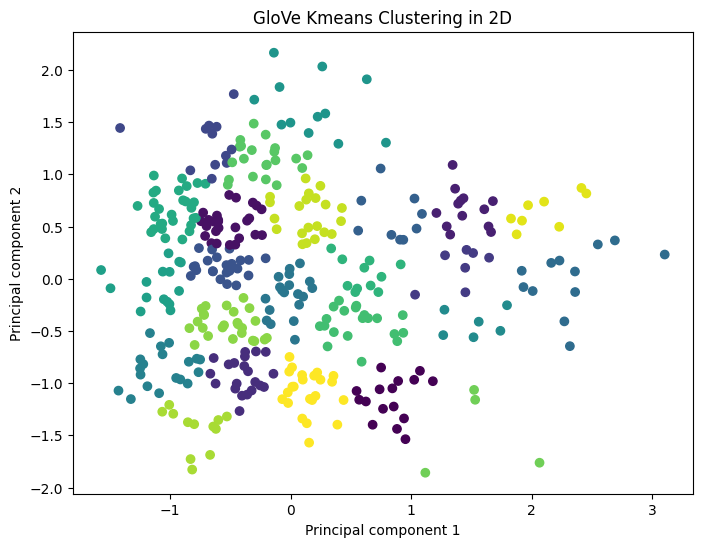

In [128]:
get_cluster_2d(exp2_vectors,model_name = 'GloVe',n_clusters = 24)



Silhouette Score: 0.26816453829906556 



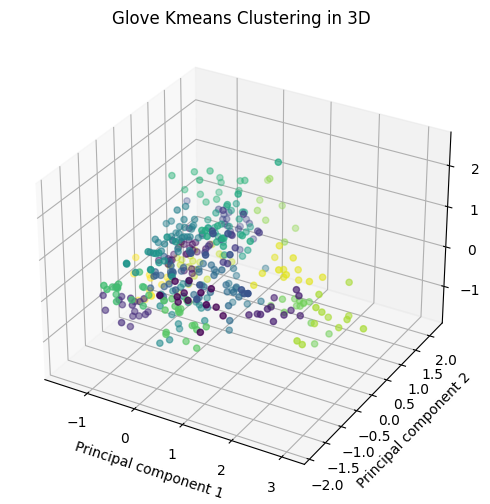

In [129]:
get_cluster_3d(exp2_vectors,model_name = 'Glove',n_clusters = 24)

## Similarity Matrix

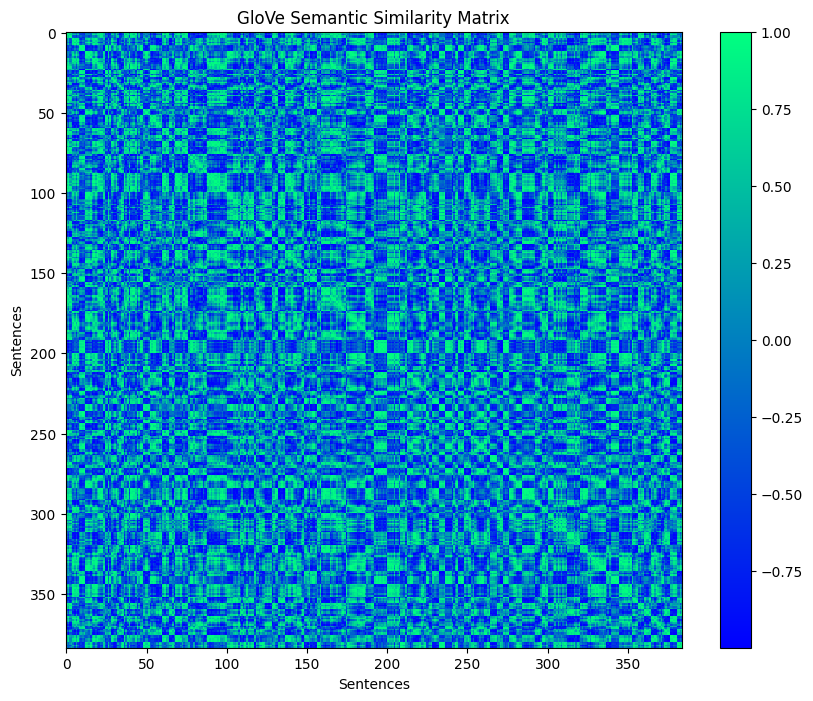

In [108]:
similarity_matrix(exp2_vectors,model_name = 'GloVe')

## WordCloud

over Model:  GloVe
cluster:  1


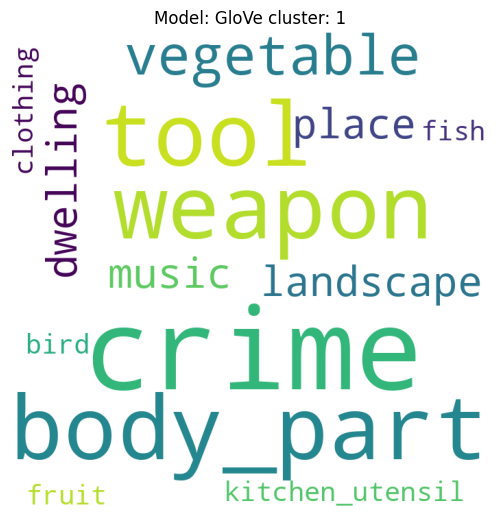

cluster:  2


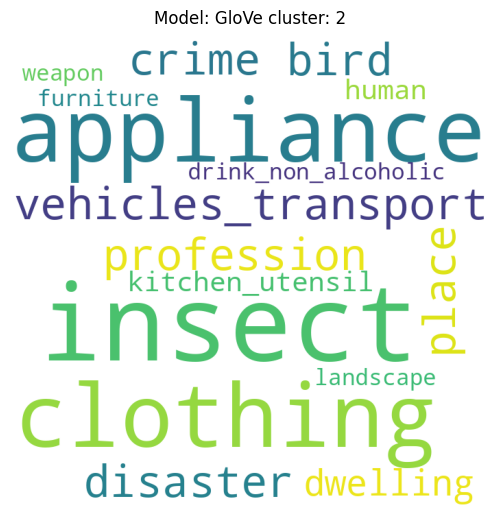

cluster:  3


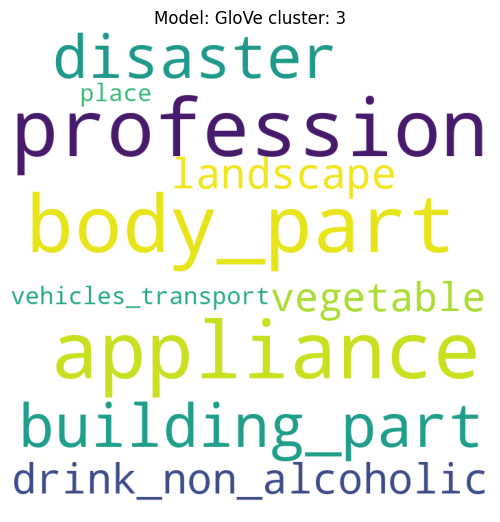

cluster:  4


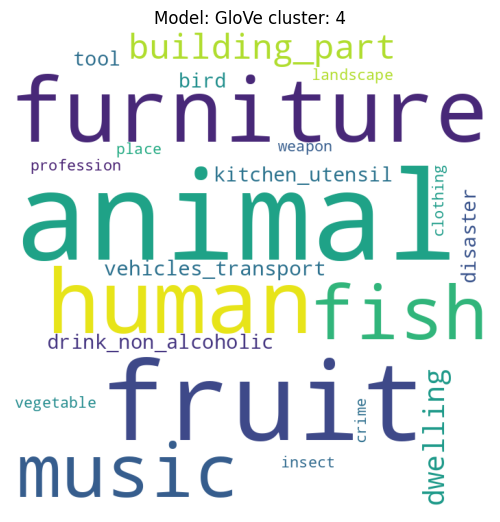

In [131]:
cluster_word_cloud(exp2_vectors, 'GloVe',4)


# **GPT**-1

In [110]:
# Mean Pooling from 'huggingface' - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [111]:
exp2_sentences = [sentence[0][0] for sentence in exp2_dict['keySentences']]

In [112]:
# Load the OpenAIGPTModel and tokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTModel.from_pretrained('openai-gpt')

In [113]:
# Tokenize sentences
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(exp2_sentences, padding=True, truncation=True, return_tensors='pt')
model.resize_token_embeddings(len(tokenizer))

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
sentence_embeddings_arr = np.array(sentence_embeddings)
pca = PCA(n_components=300)
exp2_vectors_gpt = pca.fit_transform(sentence_embeddings_arr)


## Clustering GPT-1 k-**Means**

2D


Silhouette Score: 0.3579311 



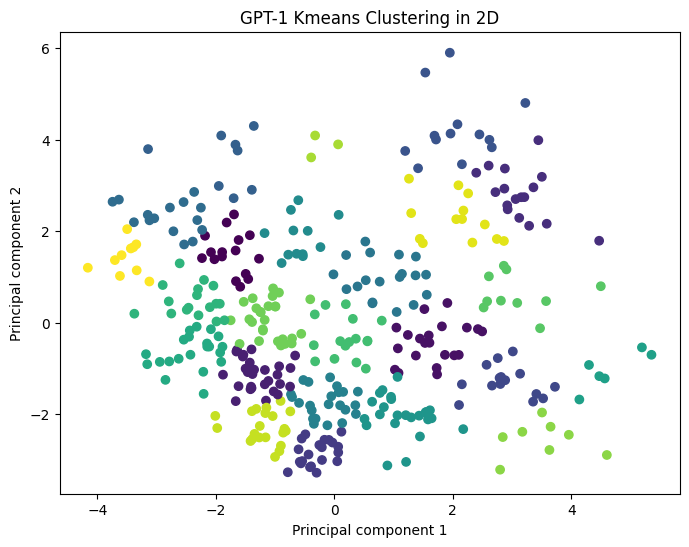

In [114]:
get_cluster_2d(exp2_vectors_gpt,model_name = 'GPT-1',n_clusters = 24)


Silhouette Score: 0.26417622 



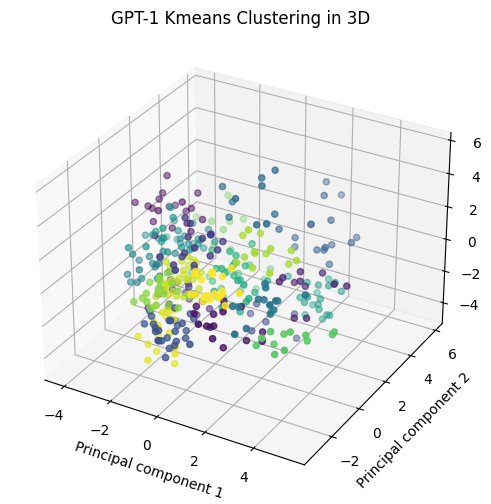

In [115]:
get_cluster_3d(exp2_vectors_gpt,model_name = 'GPT-1',n_clusters = 24)

## Similarity Matrix

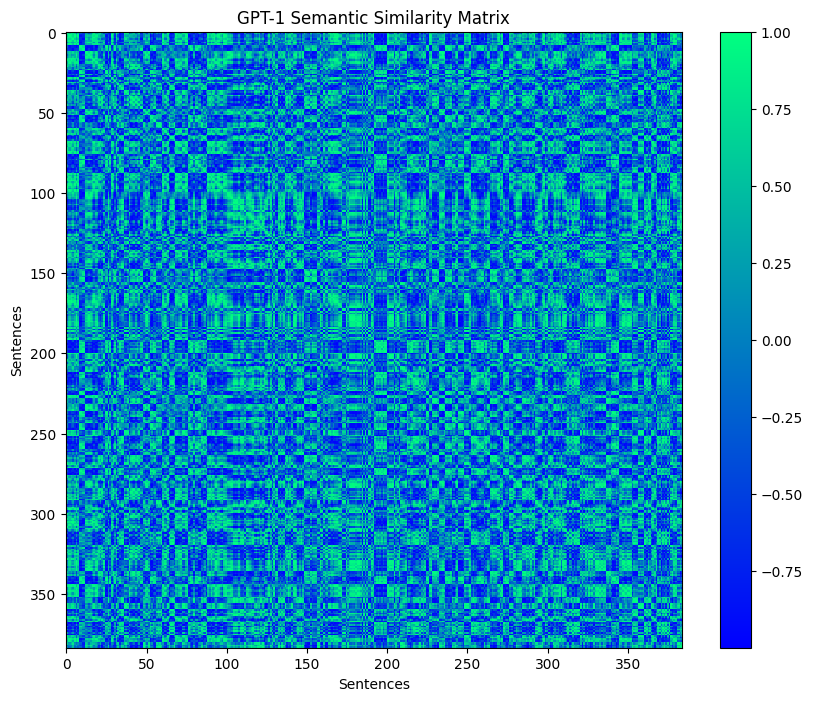

In [116]:
similarity_matrix(exp2_vectors_gpt,model_name = 'GPT-1')

## WordCloud

over Model:  GPT-1
cluster:  1


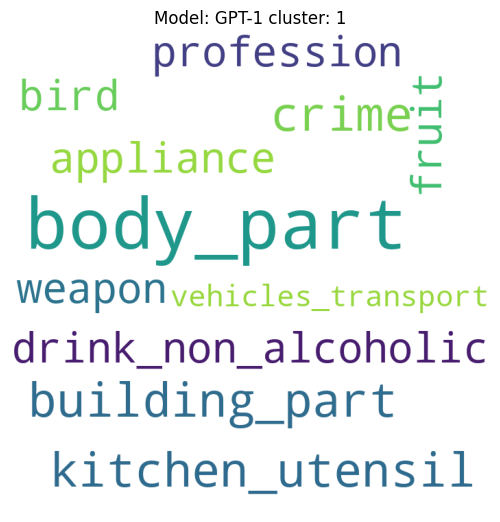

cluster:  2


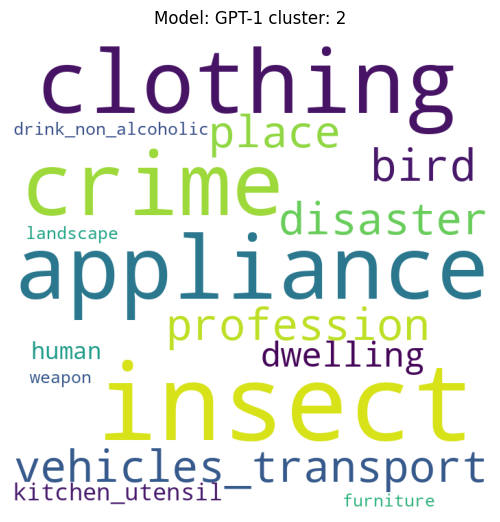

cluster:  3


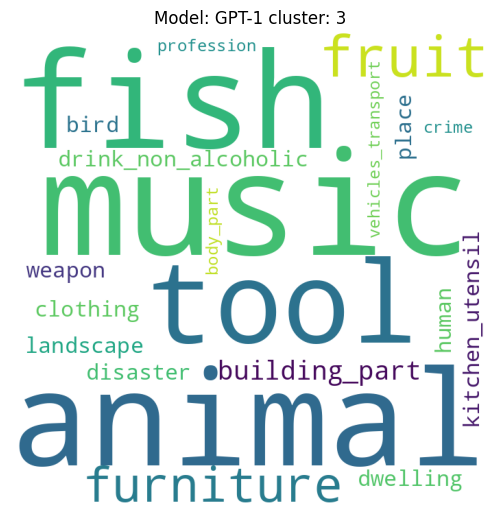

cluster:  4


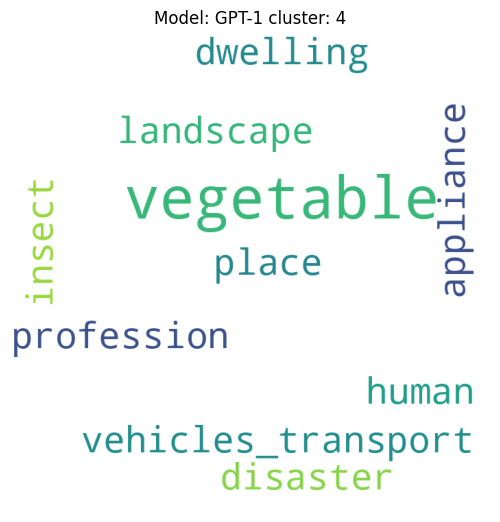

In [132]:
cluster_word_cloud(exp2_vectors_gpt,"GPT-1",4)


# **GPT**-2

In [118]:
# Load the OpenAIGPTModel and tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

In [119]:
# Tokenize sentences
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(exp2_sentences, padding=True, truncation=True, return_tensors='pt')
model.resize_token_embeddings(len(tokenizer))

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
sentence_embeddings_arr = np.array(sentence_embeddings)
pca = PCA(n_components=300)
exp2_vectors_gpt2 = pca.fit_transform(sentence_embeddings_arr)


## Clustering GPT-2 k-**Means**

2D


Silhouette Score: 0.35004357 



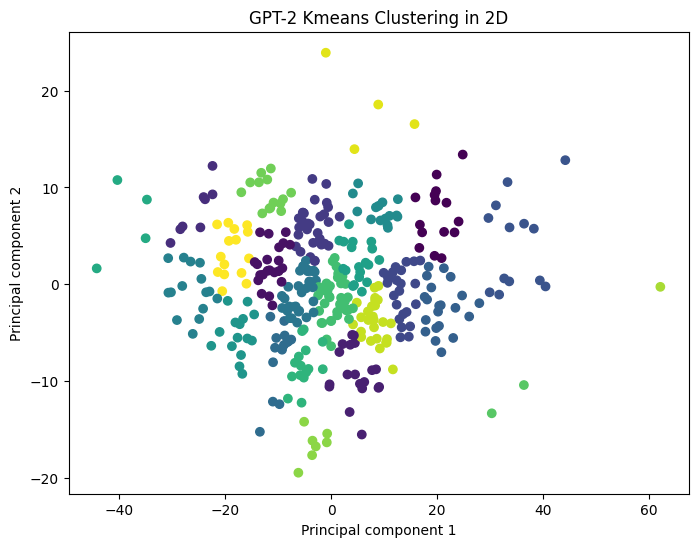

In [120]:
get_cluster_2d(exp2_vectors_gpt2,model_name = 'GPT-2',n_clusters = 24)

2d:
Silhouette Scores:

GloVe: 0.3646113
GPT-1: 0.35000888
GPT-2: 0.35262576

we can see that GloVe gave us the best result over kmeans 2d and the 2nd best is GPT-2


Silhouette Score: 0.25812358 



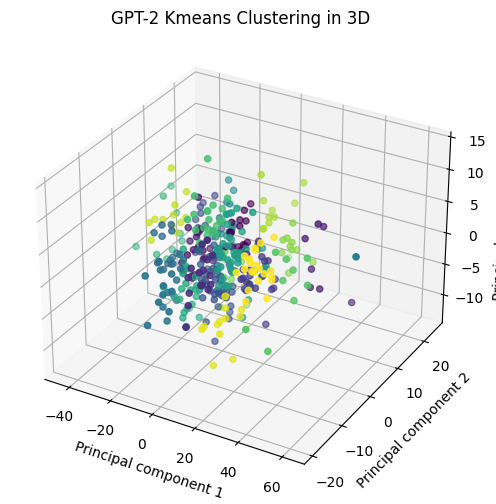

In [121]:
get_cluster_3d(exp2_vectors_gpt2,model_name = 'GPT-2',n_clusters = 24)

3d:
Silhouette Scores:

GloVe:  0.2658948
GPT-1:  0.2668159
GPT-2:  0.24525805  

we can see that GloVe gave us the best result over kmeans 2d and the 2nd best is GPT-1

## Similarity Matrix

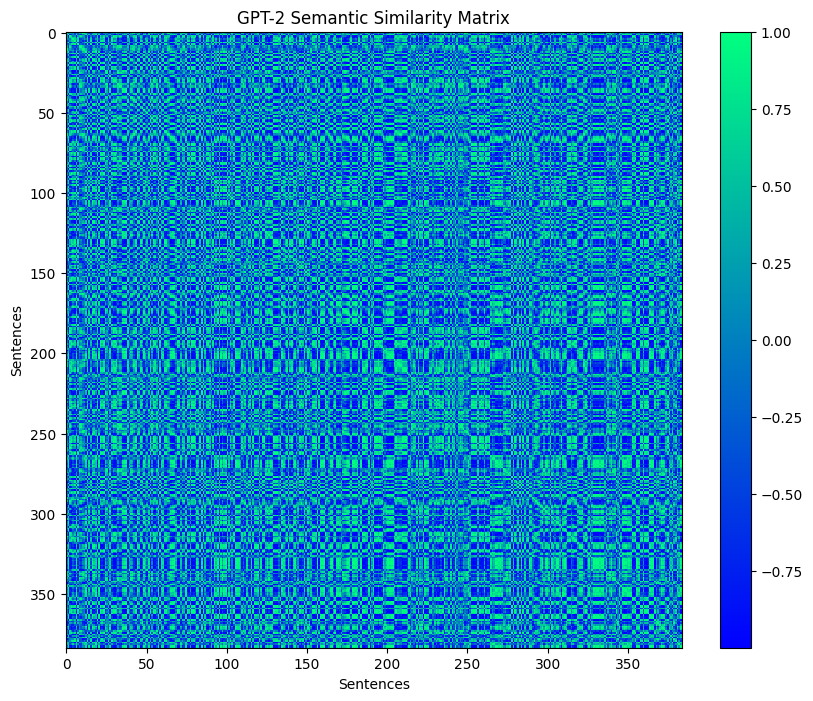

In [122]:
similarity_matrix(exp2_vectors_gpt2,model_name = 'GPT-2')

## WordCloud

over Model:  GPT-2
cluster:  1


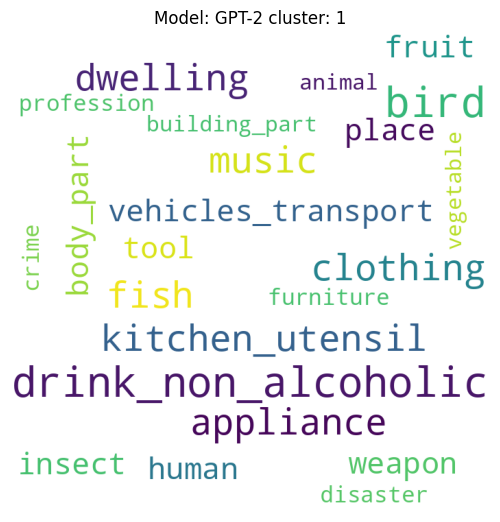

cluster:  2


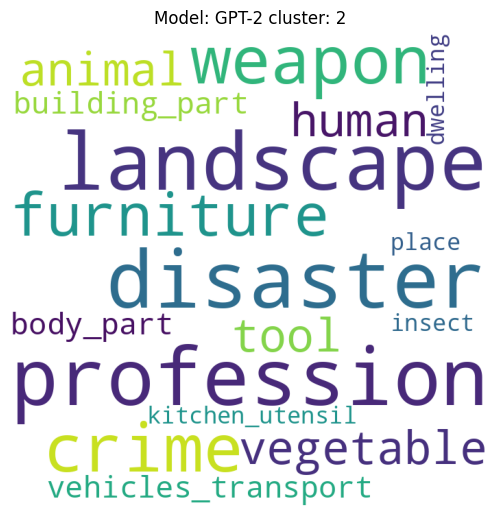

cluster:  3


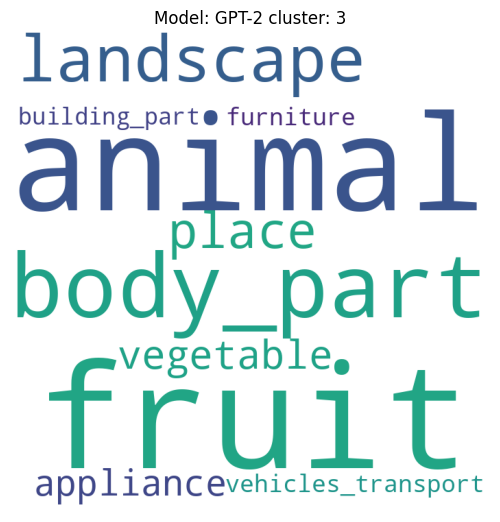

cluster:  4


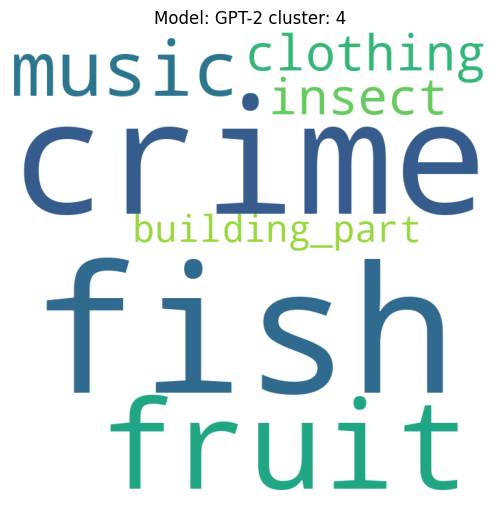

In [133]:
cluster_word_cloud(exp2_vectors_gpt2,"GPT-2",4)


# Test silhouette scores



cluster number:  2
GloVe 2D Silhouette Score: 0.38450726633187376
GloVe 3D Silhouette Score: 0.3001524680873726 

GPT-1 2D Silhouette Score: 0.3897318
GPT-1 3D Silhouette Score: 0.28780273 

GPT-2 2D Silhouette Score: 0.43276668
GPT-2 3D Silhouette Score: 0.3930482 


cluster number:  3
GloVe 2D Silhouette Score: 0.31738347278751305
GloVe 3D Silhouette Score: 0.3175068748334195 

GPT-1 2D Silhouette Score: 0.29058257
GPT-1 3D Silhouette Score: 0.29066926 

GPT-2 2D Silhouette Score: 0.33395505
GPT-2 3D Silhouette Score: 0.33359277 


cluster number:  4
GloVe 2D Silhouette Score: 0.27282208320504614
GloVe 3D Silhouette Score: 0.3045845874945474 

GPT-1 2D Silhouette Score: 0.27555794
GPT-1 3D Silhouette Score: 0.2998784 

GPT-2 2D Silhouette Score: 0.25835228
GPT-2 3D Silhouette Score: 0.28602943 


cluster number:  5
GloVe 2D Silhouette Score: 0.2352574466191144
GloVe 3D Silhouette Score: 0.29323542628224103 

GPT-1 2D Silhouette Score: 0.26566616
GPT-1 3D Silhouette Score: 0.3021587 

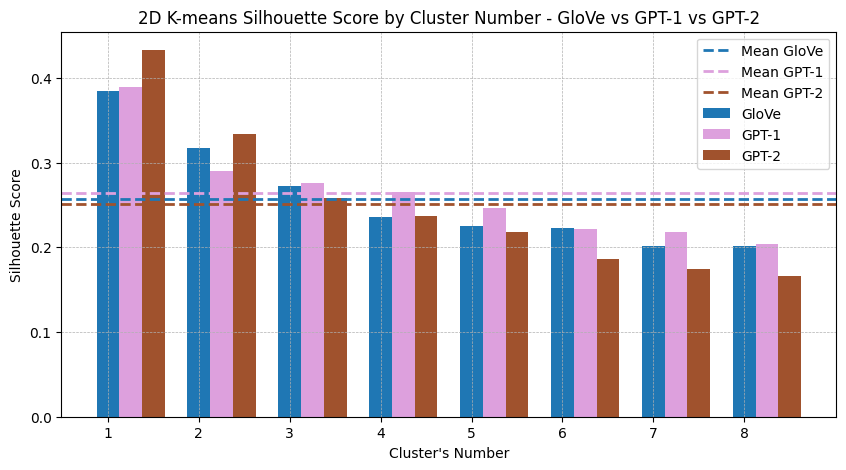

2D Mean Silhouette Score: 
GloVe: 0.25754046863940505
GPT-1: 0.2639199197292328
GPT-2: 0.2508098781108856


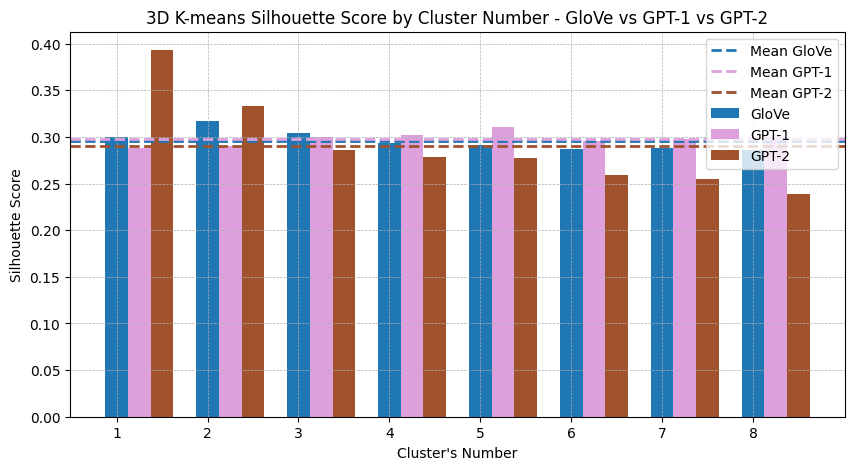

3D Mean Silhouette Score: 
GloVe: 0.29589027825110525
GPT-1: 0.2979263365268707
GPT-2: 0.2901237905025482
[[0.38450726633187376, 0.3897318, 0.43276668], [0.31738347278751305, 0.29058257, 0.33395505], [0.27282208320504614, 0.27555794, 0.25835228], [0.2352574466191144, 0.26566616, 0.2373073], [0.224918892852902, 0.2465443, 0.21801655], [0.22227249228289572, 0.22111754, 0.18604255], [0.2019643907300663, 0.21795893, 0.17384028], [0.20119770430582937, 0.20419998, 0.16619825]]


In [124]:
import warnings


def get_silhouette_score(exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2,start = 1,finish =10):
    warnings.filterwarnings("ignore")
    results2d = []
    results3d = []

    for i in range(start,finish):
        print("\ncluster number: ",i)
        index_2d = []
        index_3d = []
        for data_standardized,model_name in zip([exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2],["GloVe","GPT-1","GPT-2"]):
            pca = PCA(n_components=i)  # Specify the number of components you want to reduce to
            reduce_2d = pca.fit_transform(data_standardized)

            gpt2_clusters_kmeans = KMeans(i).fit_predict(reduce_2d)
            score_2d = silhouette_score(reduce_2d, gpt2_clusters_kmeans)
            print(model_name+" 2D Silhouette Score:", score_2d)
            index_2d.append(score_2d)

            pca = PCA(n_components=3)  # Specify the number of components you want to reduce to
            reduce_3d = pca.fit_transform(data_standardized)

            gpt2_clusters_kmeans = KMeans(i).fit_predict(reduce_3d)
            score_3d = silhouette_score(reduce_3d, gpt2_clusters_kmeans)
            print(model_name+" 3D Silhouette Score:",score_3d,"\n")
            index_3d.append(score_3d)

        results2d.append(index_2d)
        results3d.append(index_3d)


    for results,dim in zip([results2d,results3d],["2D","3D"]):
        # Data for the bar graphs
        k = len(results)
        x = np.arange(1, k+1)

        # Set the width of each bar
        bar_width = 0.25

        # Plotting the bar graphs
        plt.figure(figsize=(10, 5))
        plt.bar(x, [i[0] for i in results], label='GloVe', width=bar_width)
        plt.bar(x + bar_width, [i[1] for i in results], color='plum', label='GPT-1', width=bar_width)
        plt.bar(x + 2 * bar_width, [i[2] for i in results], color='sienna', label='GPT-2', width=bar_width)

        plt.axhline(y=np.mean([i[0] for i in results]), color='tab:blue', linestyle='--', linewidth=2, label='Mean GloVe')
        plt.axhline(y=np.mean([i[1] for i in results]), color='plum', linestyle='--', linewidth=2, label='Mean GPT-1')
        plt.axhline(y=np.mean([i[2] for i in results]), color='sienna', linestyle='--', linewidth=2, label='Mean GPT-2')

        plt.xlabel("Cluster's Number")
        plt.ylabel('Silhouette Score')
        plt.title(dim+' K-means Silhouette Score by Cluster Number - GloVe vs GPT-1 vs GPT-2')
        plt.xticks(range(1, k + 1))
        plt.grid(True, linestyle='dashed', linewidth=0.5)
        plt.legend(loc='upper right')

        # Adjusting subplot spacing
        plt.subplots_adjust(wspace=0.5)

        # Display the combined plot
        plt.show()

        print(f'{dim} Mean Silhouette Score: ')
        print(f'GloVe: {np.mean([i[0] for i in results])}')
        print(f'GPT-1: {np.mean([i[1] for i in results])}')
        print(f'GPT-2: {np.mean([i[2] for i in results])}')

    return results2d,results3d

results2d,results3d = get_silhouette_score(exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2,start = 2,finish =10)
print(results2d)


cluster number:  2
GloVe 2D Silhouette Score: 0.0597883388627147
GPT-1 2D Silhouette Score: 0.05036211
GPT-2 2D Silhouette Score: 0.30205032

cluster number:  3
GloVe 2D Silhouette Score: 0.06147336289300962
GPT-1 2D Silhouette Score: 0.051529467
GPT-2 2D Silhouette Score: 0.23303969

cluster number:  4
GloVe 2D Silhouette Score: 0.06469271975766318
GPT-1 2D Silhouette Score: 0.05581328
GPT-2 2D Silhouette Score: 0.176188

cluster number:  5
GloVe 2D Silhouette Score: 0.061468638485862925
GPT-1 2D Silhouette Score: 0.060116727
GPT-2 2D Silhouette Score: 0.16372092

cluster number:  6
GloVe 2D Silhouette Score: 0.06015987613760796
GPT-1 2D Silhouette Score: 0.060466763
GPT-2 2D Silhouette Score: 0.15884632

cluster number:  7
GloVe 2D Silhouette Score: 0.0689492777301363
GPT-1 2D Silhouette Score: 0.06397769
GPT-2 2D Silhouette Score: 0.13743676

cluster number:  8
GloVe 2D Silhouette Score: 0.06799424537048733
GPT-1 2D Silhouette Score: 0.06627723
GPT-2 2D Silhouette Score: 0.1297566


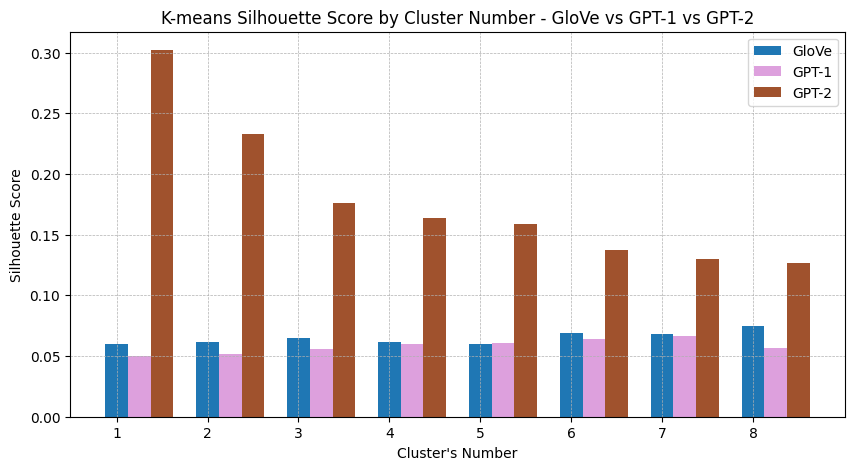

[[0.0597883388627147, 0.05036211, 0.30205032], [0.06147336289300962, 0.051529467, 0.23303969], [0.06469271975766318, 0.05581328, 0.176188], [0.061468638485862925, 0.060116727, 0.16372092], [0.06015987613760796, 0.060466763, 0.15884632], [0.0689492777301363, 0.06397769, 0.13743676], [0.06799424537048733, 0.06627723, 0.1297566], [0.07478269010253535, 0.056901734, 0.12651561]]


In [125]:
import warnings


def get_silhouette_score_full_dim(exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2,start = 1,finish =10):
    warnings.filterwarnings("ignore")
    results = []

    for i in range(start,finish):
        print("\ncluster number: ",i)
        index = []
        for data_standardized,model_name in zip([exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2],["GloVe","GPT-1","GPT-2"]):
            pca = PCA(n_components=i)  # Specify the number of components you want to reduce to
            data_standardized = data_standardized

            gpt2_clusters_kmeans = KMeans(i).fit_predict(data_standardized)
            score = silhouette_score(data_standardized, gpt2_clusters_kmeans)
            print(model_name+" 2D Silhouette Score:", score)
            index.append(score)

        results.append(index)


    results = results
    # Data for the bar graphs
    k = len(results)
    x = np.arange(1, k+1)

    # Set the width of each bar
    bar_width = 0.25

    # Plotting the bar graphs
    plt.figure(figsize=(10, 5))
    plt.bar(x, [i[0] for i in results], label='GloVe', width=bar_width)
    plt.bar(x + bar_width, [i[1] for i in results], color='plum', label='GPT-1', width=bar_width)
    plt.bar(x + 2 * bar_width, [i[2] for i in results], color='sienna', label='GPT-2', width=bar_width)

    plt.xlabel("Cluster's Number")
    plt.ylabel('Silhouette Score')
    plt.title('K-means Silhouette Score by Cluster Number - GloVe vs GPT-1 vs GPT-2')
    plt.xticks(range(1, k + 1))
    plt.grid(True, linestyle='dashed', linewidth=0.5)
    plt.legend(loc='upper right')

    # Adjusting subplot spacing
    plt.subplots_adjust(wspace=0.5)

    # Display the combined plot
    plt.show()
    return results

results = get_silhouette_score_full_dim(exp2_vectors,exp2_vectors_gpt,exp2_vectors_gpt2,start = 2,finish =10)
print(results)

Search over all number of clusters in order to analyze which performs well, and maybe for this we can know which model is better and in what cases he is senetive.

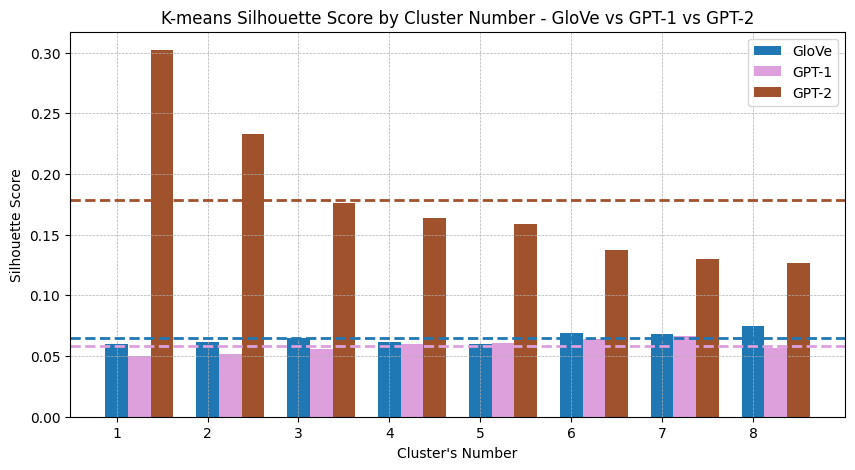

Mean Silhouette Score: 
GloVe: 0.06491364366750217
GPT-1: 0.05818062275648117
GPT-2: 0.1784442663192749

Confidence Intervals for the mean Silhouette Score: 
GloVe: ConfidenceInterval(low=0.062427746224561674, high=0.0683650791596423)
GPT-1: ConfidenceInterval(low=0.055071619120243206, high=0.061159078031778336)
GPT-2: ConfidenceInterval(low=0.1520636670691173, high=0.22267218796527552)


In [126]:
    results = results
    # Data for the bar graphs
    k = len(results)
    x = np.arange(1, k+1)

    # Set the width of each bar
    bar_width = 0.25

    # Plotting the bar graphs
    plt.figure(figsize=(10, 5))
    plt.bar(x, [i[0] for i in results], label='GloVe', width=bar_width)
    plt.bar(x + bar_width, [i[1] for i in results], color='plum', label='GPT-1', width=bar_width)
    plt.bar(x + 2 * bar_width, [i[2] for i in results], color='sienna', label='GPT-2', width=bar_width)

    plt.xlabel("Cluster's Number")
    plt.ylabel('Silhouette Score')
    plt.title('K-means Silhouette Score by Cluster Number - GloVe vs GPT-1 vs GPT-2')
    plt.xticks(range(1, k + 1))
    plt.grid(True, linestyle='dashed', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.axhline(y=np.mean([i[0] for i in results]), color='tab:blue', linestyle='--', linewidth=2, label='Mean GloVe')
    plt.axhline(y=np.mean([i[1] for i in results]), color='plum', linestyle='--', linewidth=2, label='Mean GPT-1')
    plt.axhline(y=np.mean([i[2] for i in results]), color='sienna', linestyle='--', linewidth=2, label='Mean GPT-2')
# ['tab:blue', 'plum', 'sienna']
    # Adjusting subplot spacing
    plt.subplots_adjust(wspace=0.5)

    # Display the combined plot
    plt.show()

silhouette_score_ex2_glove_mean_CI = scipy.stats.bootstrap(([i[0] for i in results],), np.mean, confidence_level=0.9).confidence_interval
silhouette_score_ex2_gpt_mean_CI = scipy.stats.bootstrap(([i[1] for i in results],), np.mean, confidence_level=0.9).confidence_interval
silhouette_score_ex2_gpt2_mean_CI = scipy.stats.bootstrap(([i[2] for i in results],), np.mean, confidence_level=0.9).confidence_interval

print('Mean Silhouette Score: ')
print(f'GloVe: {np.mean([i[0] for i in results])}')
print(f'GPT-1: {np.mean([i[1] for i in results])}')
print(f'GPT-2: {np.mean([i[2] for i in results])}')
print()
print('Confidence Intervals for the mean Silhouette Score: ')
print(f'GloVe: {silhouette_score_ex2_glove_mean_CI}')
print(f'GPT-1: {silhouette_score_ex2_gpt_mean_CI}')
print(f'GPT-2: {silhouette_score_ex2_gpt2_mean_CI}')